In [1]:
import sys
import os
from time import time 
from datetime import timedelta, datetime
import gc
from collections import defaultdict
import xgboost as xgb

from sklearn import metrics
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
sys.path.append('../')
from utils import (
    check_columns, 
    check_category_column, 
    save_model, 
    transform_category_column,
    get_time_diff,
    load_model,
    LogManager,
    timer,
    standard_scale,
    log_scale,
    remove_cont_cols_with_small_std,
    correct_column_type
)
import conf
from mlpipeline.feature_engineering import (
    USING_LABEL,
    FAULT_LABEL,
)
from mlpipeline import (
    feature_engineering,
    train,
    predict,
)
# global setting
LogManager.created_filename = os.path.join(conf.LOG_DIR, 'xgboost.log')
LogManager.log_handle = 'file'
logger = LogManager.get_logger(__name__)

In [3]:
CLASS_NAME = ['无故障','有故障']
EARLY_STOPPING_ROUNDS=10
CLS_RANKING = 0.996  # 0.996,0.994
NUM_SUBMISSION = 40

In [4]:
def _f1_score( eval_df):
    def __precision():
            tmp_df = eval_df[eval_df['pred']==1]
            mask = tmp_df['pred']==tmp_df['tag']
            ntpp = len(tmp_df[mask])
            npp = len(tmp_df)
            return  ntpp / npp
    def __recall():
            fault_tmp_df = eval_df[eval_df['flag']==1] 
            npr = len(fault_tmp_df)
            pred_tmp_df = eval_df[eval_df['pred']==1]
            mask =  (pred_tmp_df['model'].isin(fault_tmp_df['model'])) & (pred_tmp_df['serial_number'].isin(fault_tmp_df['serial_number']))
            ntpr = len(pred_tmp_df[mask])
            return ntpr / npr
    precision, recall = __precision(), __recall()
    return precision, recall, 2* precision * recall / (precision + recall)

In [5]:
def _log_best_round_of_model(model, 
                             evals_result,
                             valid_index,
                             metric):
        assert hasattr(model, 'best_iteration'), 'just can logger object that has best_iteration attribute'
        n_estimators = model.best_iteration
        logger.info('eval最优轮数: %s, eval最优%s: %s' %(
                                                       n_estimators, 
                                                       metric,            
                                                       evals_result[valid_index][metric][n_estimators]))

In [10]:
def _train_valid_split(
                       fe_df,
                       train_start_date,
                       train_end_date,
                       valid_start_date,
                       valid_end_date,  
                       train_on_model_id,
                       eval_on_model_id,
                       use_next_month_fault_data,
                       next_month_start_date,
                       next_month_end_date,
                       use_2017_fault_data,
                       use_log,
):
    
    
    index_cols, cate_cols, cont_cols, label_cols = check_columns(fe_df.dtypes.to_dict())
    assert cate_cols is not None or cont_cols is not None, 'feature columns are empty' 
#     cate_transform_dict = check_category_column(fe_df, cate_cols)
#     fe_df = transform_category_column(fe_df, cate_transform_dict)
    logger.info('连续性特征数量: %s' % len(cont_cols))
    logger.info('离散性特征数量: %s' % len(cate_cols))
    
#     fe_df[cont_cols].fillna(DEFAULT_MISSING_FLOAT,inplace=True)
#     fe_df[cate_cols].fillna(0,inplace=True)    
    train_fe_df = fe_df[(fe_df['dt'] >= train_start_date) & (fe_df['dt']<=train_end_date)] 
    
    
    # add 2017 fault data into train
    if use_2017_fault_data:
        fault_2017_df = fe_df[fe_df['dt']<'2018-01-01']
        if not fault_2017_df.empty:
                train_fe_df = pd.concat([fault_2017_df[fault_2017_df[USING_LABEL]==FAULT_LABEL],train_fe_df], axis=0)
    
    # add next_month_fault_data into train
    if use_next_month_fault_data:
            next_month_fe_df = fe_df[(fe_df['dt']>=next_month_start_date) & (fe_df['dt']<=next_month_end_date)]
            if not next_month_fe_df.empty:
                next_month_fault_disk_df = next_month_fe_df[next_month_fe_df['flag']==1]
                next_month_tag_df = next_month_fe_df[next_month_fe_df['tag']==1]
                mask = next_month_tag_df.model.isin(next_month_fault_disk_df.model)
                mask &= next_month_tag_df.serial_number.isin(next_month_fault_disk_df.serial_number)
                train_fe_df = pd.concat([next_month_tag_df[mask],train_fe_df], axis=0)
              
    if train_on_model_id !=None:
        train_fe_df = train_fe_df[train_fe_df.model==train_on_model_id]
    val_fe_df = fe_df[(fe_df['dt'] >= valid_start_date) & (fe_df['dt']<=valid_end_date)]
    if eval_on_model_id !=None:
        val_fe_df = val_fe_df[val_fe_df.model==eval_on_model_id]     
    train_fe_df.reset_index(drop=True,inplace=True)
    val_fe_df.reset_index(drop=True,inplace=True)  
    del fe_df
    gc.collect()
    
    if cate_cols and not cont_cols:
        train_x = train_fe_df[cate_cols]
        val_x = val_fe_df[cate_cols + index_cols]
    elif not cate_cols and cont_cols:
        if use_log:
                logger.info("使用log: %s"%use_log)
                train_fe_df, val_fe_df = log_scale(cont_cols, 
                                           train_fe_df, 
                                           val_fe_df)
        train_x = train_fe_df[cont_cols]
        val_x = val_fe_df[cont_cols]    
    else:
        if use_log:
                logger.info("使用log: %s"%use_log)
                train_fe_df, val_fe_df = log_scale(cont_cols, 
                                           train_fe_df, 
                                           val_fe_df)
        
        train_x = pd.concat([train_fe_df[cate_cols],
                             train_fe_df[cont_cols]],
                             axis=1)
        val_x = pd.concat([val_fe_df[cate_cols],
                     val_fe_df[cont_cols],
                           ], 
                           axis=1)
       
    train_y = train_fe_df[label_cols]
    val_y = val_fe_df[label_cols]
    
    return  (index_cols, cate_cols, cont_cols, label_cols), train_fe_df, val_fe_df, train_x, train_y, val_x, val_y


In [7]:
fe_df = pd.read_feather(os.path.join(conf.DATA_DIR, "sample_by_power_on_hours_0.3_fe_df_01_01_round_2_with_smart_9raw.feather"))

In [19]:
fe_df.tail()

,degradation_err_weight,degradation_err_weight_diff_for_last_period_7,degradation_err_weight_max_7,degradation_err_weight_min_7,degradation_err_weight_std_7,dt,err_weight,err_weight_diff_for_last_period_7,err_weight_max_7,err_weight_min_7,...,smart_5raw_slope_for_last_duration_7,smart_5raw_std_7,smart_7_normalized,smart_7_normalized_diff_for_last_period_7,smart_7_normalized_max_7,smart_7_normalized_min_7,smart_7_normalized_std_7,smart_9_normalized,smart_9raw_in_day_unit,tag
11532609,37.520087,0.321371,37.520087,37.198715,1.214669e-01,2018-07-31,3.844617,0.017758,3.844617,3.560488,...,0.0,0.0,90.0,0.0,90.0,90.0,1.643637e-07,33.0,1209.0,0
11532610,39.544725,0.000000,39.544725,39.544725,4.654029e-07,2018-07-31,3.826859,0.142064,3.889012,3.631521,...,0.0,0.0,93.0,0.0,93.0,93.0,0.000000e+00,33.0,1218.0,0
11532611,36.598823,0.000000,36.598823,36.598823,3.701434e-07,2018-07-31,4.128746,0.230855,4.128746,3.880133,...,0.0,0.0,87.0,0.0,87.0,87.0,5.305455e-07,29.0,1090.0,0
11532612,28.200322,0.000000,28.200322,28.200322,0.000000e+00,2018-07-31,1.758047,0.062153,1.758047,1.518313,...,0.0,0.0,94.0,0.0,94.0,94.0,1.353267e-06,6.0,255.0,0
11532613,40.921265,0.321371,40.921265,40.599894,1.214669e-01,2018-07-31,3.560488,0.266371,4.128746,3.560488,...,0.0,0.0,94.0,0.0,94.0,94.0,0.000000e+00,41.0,1501.0,0


In [13]:
cols, train_fe_df, val_fe_df, train_x, train_y, val_x, val_y = _train_valid_split(fe_df,
                                                                                       train_start_date='2018-01-01',
                                                                                       train_end_date='2018-05-31',
                                                                                       valid_start_date='2018-07-01',
                                                                                       valid_end_date='2018-07-31',  
                                                                                       train_on_model_id=None,
                                                                                       eval_on_model_id=None,
                                                                                       use_next_month_fault_data=False,
                                                                                       next_month_start_date=None,
                                                                                       next_month_end_date=None,
                                                                                       use_2017_fault_data=False,
                                                                                       use_log=False)

In [14]:
index_cols, cate_cols, cont_cols, label_cols = cols
val_x_index = val_fe_df[index_cols]
feature_name = train_x.columns

In [22]:
cat_cols = [col for col in train_x.columns if str(train_x[col].dtypes) == "category"]
cat_cols

['model_type', 'smart_184raw', 'smart_188raw', 'smart_197raw', 'smart_198raw']

In [23]:
train_x = pd.get_dummies(train_x, columns=cate_cols)
val_x = pd.get_dummies(valid_x, columns=cate_cols)

In [24]:
num_train_pos = len(train_fe_df[train_fe_df[USING_LABEL]==FAULT_LABEL])
num_train_neg = len(train_fe_df[train_fe_df[USING_LABEL]!=FAULT_LABEL])
ratio_train_pos_neg = round(num_train_pos/num_train_neg, 5)
logger.info('训练集正负样本比:%s:%s(i.e. %s)'%(num_train_pos,
                                            num_train_neg,
                                            ratio_train_pos_neg))                                       

num_valid_pos = len(val_fe_df[val_fe_df[USING_LABEL]==FAULT_LABEL])
num_valid_neg = len(val_fe_df[val_fe_df[USING_LABEL]!=FAULT_LABEL])
ratio_valid_pos_neg = round(num_valid_pos/num_valid_neg, 5)
logger.info('验证集正负样本比:%s:%s(i.e. %s)'%(num_valid_pos,
                                            num_valid_neg,
                                            ratio_valid_pos_neg))
train_start_time = time()
train_set = xgb.DMatrix(data=train_x, label=train_y[USING_LABEL])
val_set = xgb.DMatrix(data=val_x, label=valid_y[USING_LABEL])
evals_result = {}

In [25]:
model_params={
            'objective': 'binary:logistic', 
            'eta':0.001,
    #'learning_rate': 0.001, 
            'eval_metric': ['auc'],
            'lambda': 1.8310435018078826,
            'num_boost_round': 100, 
            'subsample': 0.8341500491577648,
            'num_threads': 12, 
            'random_state': 2019,
            'gamma':0.2,
            'colsample_bytree': 0.3727020339353229, 
            'device': 'cpu'
            }
        

In [26]:
logger.info('eval参数:%s' % model_params)
model = xgb.train(params = model_params, num_boost_round = model_params["num_boost_round"], dtrain = train_set, evals = [(train_set, 'train'), (val_set, 'eval')],
                early_stopping_rounds=EARLY_STOPPING_ROUNDS, evals_result=evals_result)

[10:18:15] WARNING: /workspace/src/gbm/gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-auc:0.70313	eval-auc:0.68481
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.71232	eval-auc:0.70938
[2]	train-auc:0.71595	eval-auc:0.71601
[3]	train-auc:0.71596	eval-auc:0.71603
[4]	train-auc:0.71597	eval-auc:0.71603
[5]	train-auc:0.71666	eval-auc:0.71600
[6]	train-auc:0.73127	eval-auc:0.71122
[7]	train-auc:0.73423	eval-auc:0.71915
[8]	train-auc:0.73415	eval-auc:0.71803
[9]	train-auc:0.73415	eval-auc:0.71803
[10]	train-auc:0.73406	eval-auc:0.71757
[11]	train-auc:0.73343	eval-auc:0.71692
[12]	train-auc:0.73343	eval-auc:0.71692
[13]	train-auc:0.73323	eval-auc:0.71671
[14]	train-auc:0.73322	eval-auc:0.71671
[15]	train-auc:0.73315	eval-auc:0.71670
[16]	train-a

In [31]:
_log_best_round_of_model(model, evals_result, 'eval', 'auc')

In [32]:
def _feature_imp_plot_lgb(model, 
                          features_name,
                          train_start_time,
                          save_feat_important=False,
                          max_num_features=30,
                          font_scale=0.7):
        """
        visualize the feature importance for lightgbm classifier
        """
        feat_imp = pd.DataFrame.from_dict(model.get_score(importance_type='gain'), orient="index", columns=['Value'])
        feat_imp = feat_imp.reset_index().rename(columns = {"index":"Feature"}).sort_values(by="Value", ascending=False)
        #feat_imp = pd.DataFrame(zip(model.get_score(importance_type='gain'), features_name),
                                #columns=['Value', 'Feature']).sort_values(by="Value", ascending=False)
        logger.info('特征重要性：%s'%feat_imp)

        # plot importance
        fig, ax = plt.subplots(figsize=(12, 4))
        top_data = feat_imp.iloc[0:max_num_features]
        top_feat_name = top_data['Feature'].values
        sns.barplot(x="Value", y="Feature", data=top_data)
        ax.set_title('lgb top %s features important'% max_num_features)
        ax.set_yticklabels(labels=top_feat_name)
        pic_name = 'lgb_top_%s_feature_importance_%s.png' % (max_num_features, train_start_time)
        if save_feat_important:
            pic_save_path = os.path.join(conf.FIGURE_DIR, pic_name)
            plt.savefig(pic_save_path)
            logger.info('%s 保存至%s'% (pic_name, pic_save_path))
        plt.show()

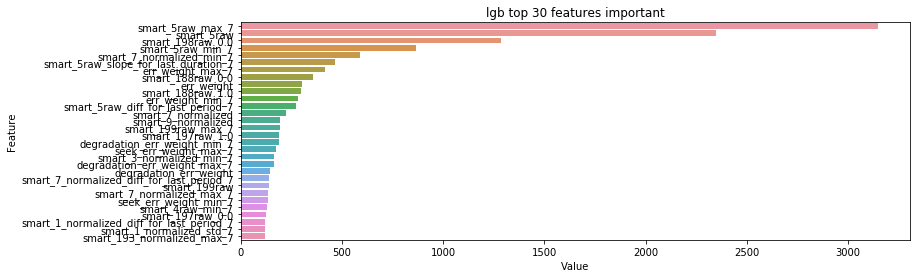

In [155]:
_feature_imp_plot_lgb(model,
                                  train_x.columns,
                                  train_start_time
                                 )

In [115]:
def _eval(
          model,
          val_x_index,
          val_x,
          val_y,
          valid_start_date,
          valid_end_date,
          ):
    # eval on valid set 
    results = []
    eval_df = pd.concat([val_x_index,val_x, val_y], axis=1)
    eval_df = eval_df.sort_values('dt')
    valid_start_date, valid_end_date = eval_df.iloc[0]['dt'], eval_df.iloc[-1]['dt'] 
    valid_date_range = pd.date_range(valid_start_date, 
                                     valid_end_date, 
                                     freq='D')
    for valid_date in valid_date_range:
        logger.info('验证日期：%s'%valid_date)
        sub_eval_df = eval_df[eval_df.dt==valid_date]
        
        sub_eval_df.loc[:,'prob'] = model.predict(data=xgb.DMatrix(data=sub_eval_df[val_x.columns]))
        #sub_eval_df.loc[:,'prob'] = model.predict(data=np.array(sub_eval_df[val_x.columns]))
        
        sub_eval_df.loc[:,'rank'] = sub_eval_df['prob'].rank()
        sub_eval_df.loc[:,'pred'] = (sub_eval_df['rank']>=sub_eval_df.shape[0] * CLS_RANKING).astype(int)
        sub_eval_df = sub_eval_df.loc[sub_eval_df.pred == FAULT_LABEL]
        sub_eval_df = sub_eval_df.sort_values('prob', ascending=False)
        top_sub_eval_df = sub_eval_df.reset_index(drop=True, inplace=False).iloc[:NUM_SUBMISSION]
        logger.info('原始预测为fault disk的个数：%s'%len(sub_eval_df))
        results.append(top_sub_eval_df)
    pred_df = pd.concat(results)
    pred_df.drop_duplicates(['model','serial_number'], inplace=True)
    logger.info('最终预测个数:%s'%len(pred_df))
    eval_df = eval_df.merge(pred_df[index_cols + ['prob','rank','pred']],how='left',on=index_cols)
    eval_df.loc[:,'pred'] = eval_df['pred'].fillna(0)
    acc = metrics.accuracy_score(eval_df[USING_LABEL], eval_df['pred'])
    report = metrics.classification_report(eval_df[USING_LABEL], eval_df['pred'], target_names=CLASS_NAME, digits=4)
    confusion = metrics.confusion_matrix(eval_df[USING_LABEL], eval_df['pred'])
    msg = 'Val Acc: {0:>6.2%}'
    logger.info(msg.format(acc))
    logger.info("Precision, Recall and F1-Score...")
    logger.info(report)
    logger.info("Confusion Matrix...")
    logger.info(confusion)

    # eval on competition index by topk 
    precision, recall, f1_score = _f1_score(
                                            eval_df,
                                           )
    logger.info("竞赛recall: %s"% recall)
    logger.info("竞赛precision: %s"%precision)
    logger.info("竞赛f1-score: %s"%f1_score)
    
    return eval_df, f1_score

In [156]:
eval_df, f1_score = _eval(
                                       model,
                                       val_x_index,
                                       val_x,
                                       valid_y,
                                       valid_start_date='2018-07-01',
                                    valid_end_date='2018-07-31')

In [157]:
f1_score

0.2239128555373044

In [158]:
model_path = os.path.join(conf.TRAINED_MODEL_DIR, "%s.model.%s" % ("xgboost", datetime.now().isoformat()))
save_model(model_path, 
                          (index_cols, 
                           cate_cols, 
                           cont_cols,
                           label_cols, 
                           train_x.columns,
                           model)
                         )

In [50]:
index_cols, cate_cols, cont_cols, label_cols, train_x.columns, model_new = load_model(model_path)

In [46]:
eval_df, f1_score = _eval(
                                       model_new,
                                       val_x_index,
                                       val_x,
                                       valid_y,
                                       valid_start_date='2018-07-01',
                                    valid_end_date='2018-07-31')

In [47]:
f1_score

0.2291881745659315

In [66]:
@timer(logger)
def inference_pipeline_ensemble_tree(fe_df, 
                                     use_standard,
                                     use_log,
                                     scaler,
                                     model_save_path=None,
                                     ):
    
    index_cols, cate_cols, cont_cols, label_cols, features, model = load_model(model_save_path)
    fe_df = fe_df.sort_values('dt')
    start_date, end_date = fe_df.iloc[0]['dt'], fe_df.iloc[-1]['dt'] 
    date_range = pd.date_range(start_date, end_date, freq='D')
#     lgb.plot_tree(model, dpi=600, show_info=['split_gain','internal_value']
#                  )
#     plt.show()
#     fe_df = transform_category_column(fe_df, cate_transform_dict)
#     print(cont_cols, model.params, model.best_iteration)
#     print(model.feature_importance())
    assert cate_cols is not None or cont_cols is not None, 'feature columns are empty' 
    
    submission_df = pd.DataFrame() 
    for date in date_range:
        logger.info('预测日期：%s'%date)
        sub_fe_df = fe_df[fe_df.dt==date]
        if cate_cols and not cont_cols:
            test_features = sub_fe_df[cate_cols]
        elif not cate_cols and cont_cols:
            if use_standard:
                    logger.info("使用标准化: %s"%use_standard)
                    sub_fe_df = scaler.transform(cont_cols, sub_fe_df)
            if use_log:
                    logger.info("使用log: %s"%use_log)
                    sub_fe_df,_ = log_scale(cont_cols, sub_fe_df)
            test_features = sub_fe_df[cont_cols]
        else:
            if use_standard:
                    logger.info("使用标准化: %s"%use_standard)
                    sub_fe_df = scaler.transform(cont_cols, sub_fe_df)
            if use_log:
                    logger.info("使用log: %s"%use_log)
                    sub_fe_df,_ = log_scale(cont_cols, sub_fe_df)
            test_features = pd.concat([sub_fe_df[cate_cols], sub_fe_df[cont_cols]],
                                      axis=1)

        test_features = pd.get_dummies(test_features, columns=cate_cols)
        
        test_x = test_features[features]
        ret = sub_fe_df[index_cols]
        
        test_x = xgb.DMatrix(data=test_x)
        
        ret.loc[:,'prob'] = model.predict(test_x)
        ret.loc[:,'rank'] = ret['prob'].rank()
        ret.loc[:,'label'] = (ret['rank']>=ret.shape[0] * CLS_RANKING).astype(int)
        sub_submission_df = ret.loc[ret.label ==  FAULT_LABEL]
        sub_submission_df = sub_submission_df.sort_values('prob', ascending=False)
        top_sub_submission_df = sub_submission_df.reset_index(drop=True, inplace=False).iloc[:NUM_SUBMISSION]
        logger.info('原始预测为fault disk的个数：%s'%len(sub_submission_df))
        
        top_sub_submission_df.loc[:,'manufacturer'] = 'A'
        submission_df = pd.concat([submission_df, top_sub_submission_df[['manufacturer',
                                                                         'model',
                                                                         'serial_number',
                                                                         'dt']]])
    csv_save_filename = 'submission_%s.csv'%datetime.now().isoformat()
    csv_save_path = os.path.join(conf.ROOT_DIR, csv_save_filename)
    submission_df = submission_df.drop_duplicates(['serial_number', 'model'])
    submission_df.to_csv(csv_save_path, index=False, header=False)
    zip_save_path = os.path.join(conf.ROOT_DIR, 'result_test.zip')
    #with ZipFile(zip_save_path,'w') as zf:
              #zf.write(csv_save_path, compress_type=ZIP_DEFLATED)
   
    logger.info('最终提交样本个数：%s'%len(submission_df))
    logger.info('csv文件%s已保存至%s，zip文件已保存至%s'%( 
                                                           csv_save_filename,
                                                           csv_save_path,
                                                           zip_save_path
        ))
    
    return submission_df

In [54]:
import conf
from mlpipeline.train import (
                    CLS_RANKING,
                    NUM_SUBMISSION)
from mlpipeline.feature_engineering import (
    USING_LABEL,
    FAULT_LABEL,
    feature_engineering
)

In [55]:
@timer(logger)
def predict( 
    model_name='lgb', 
    pred_start_date='2018-09-01',
    pred_end_date='2018-09-30',
    use_standard=False,
    scaler='',
    use_log=False,
    num_processes=17,
    is_train=False
):
    logger.info("开始预测, 当前使用模型:%s"% (model_name))
    test_fe_df = feature_engineering(
                                     pred_start_date = pred_start_date,
                                     pred_end_date = pred_end_date,
                                     is_train=False,
                                     num_processes=num_processes)
    logger.info("预测样本数:%s, 分类阈值: %s, 分类每日截断个数：%s" % (test_fe_df.shape[0],
                                                                CLS_RANKING,
                                                                NUM_SUBMISSION))
    model_save_path = get_latest_model(conf.TRAINED_MODEL_DIR, '%s.model' % model_name)
    if model_name == 'lgb':
         submission_df = inference_pipeline_ensemble_tree(test_fe_df, 
                                                              use_standard,
                                                              use_log,
                                                              scaler,
                                                              model_save_path=model_save_path,
                                                              )
    elif model_type == 'stacking':
        # TODO:增加stacking部分inference pipeline
        raise NotImplementedError('%s has not been implemented' % model_name)
    else:
        # TODO:增加神经网络部分
        raise NotImplementedError('%s was not been implemented' % model_name)
   
    logger.info("%s预测完成!" % model_name) 
    return  submission_df


predict()

2020-04-03 15:13:31,179 - mlpipeline.feature_engineering - INFO - feature_engineering开始
2020-04-03 15:13:31,182 - mlpipeline.feature_engineering - INFO - 训练数据特征工程: False，数据集截断起始日期：None, 数据集截断结束日期：None
2020-04-03 15:13:31,183 - mlpipeline.feature_engineering - INFO - _load_data_into_dataframe开始
2020-04-03 15:13:31,184 - mlpipeline.feature_engineering - INFO - 加载数据集: ../tcdata/disk_sample_smart_log_round2
2020-04-03 15:13:31,185 - mlpipeline.feature_engineering - INFO - _get_pred_data开始


FileNotFoundError: [Errno 2] File b'../tcdata/disk_sample_smart_log_round2/disk_sample_smart_log_20180814_round2.csv' does not exist: b'../tcdata/disk_sample_smart_log_round2/disk_sample_smart_log_20180814_round2.csv'

In [67]:
submission_df = inference_pipeline_ensemble_tree(val_fe_df, False, False, '',
                                                              model_save_path=model_path
                                                              )

In [13]:
model_path = os.path.join(conf.TRAINED_MODEL_DIR, "xgboost.model.2020-04-03T17:45:10.170709")
index_cols, cate_cols, cont_cols, label_cols, train_x.columns, model_xgb = load_model(model_path)

In [14]:
model_xgb.predict(xgb.DMatrix(data=val_x), pred_leaf=True)

array([[38, 63, 58, ..., 55, 74, 71],
       [41, 61, 65, ..., 52, 69, 66],
       [42, 61, 65, ..., 52, 74, 66],
       ...,
       [42, 63, 65, ..., 56, 74, 75],
       [38, 61, 62, ..., 51, 77, 64],
       [42, 61, 65, ..., 52, 77, 66]], dtype=int32)

In [39]:
xgb_pred = model_xgb.predict(xgb.DMatrix(data=train_x), pred_leaf=True)

In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

In [40]:
encoder = OneHotEncoder()

In [43]:
encoder.fit(xgb_pred)
xgb_one = encoder.transform(xgb_pred).toarray()

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [44]:
xgb_one.shape

(47832, 1373)

In [45]:
def _eval(
          model,
          val_x_index,
          val_x,
          val_y,
          valid_start_date,
          valid_end_date,
          ):
    # eval on valid set 
    results = []
    eval_df = pd.concat([val_x_index,val_x, val_y], axis=1)
    eval_df = eval_df.sort_values('dt')
    valid_start_date, valid_end_date = eval_df.iloc[0]['dt'], eval_df.iloc[-1]['dt'] 
    valid_date_range = pd.date_range(valid_start_date, 
                                     valid_end_date, 
                                     freq='D')
    for valid_date in valid_date_range:
        logger.info('验证日期：%s'%valid_date)
        sub_eval_df = eval_df[eval_df.dt==valid_date]
        
        sub_eval_df.loc[:,'prob'] = model.predict(data=xgb.DMatrix(data=sub_eval_df[val_x.columns]))
        #sub_eval_df.loc[:,'prob'] = model.predict(data=np.array(sub_eval_df[val_x.columns]))
        
        sub_eval_df.loc[:,'rank'] = sub_eval_df['prob'].rank()
        sub_eval_df.loc[:,'pred'] = (sub_eval_df['rank']>=sub_eval_df.shape[0] * CLS_RANKING).astype(int)
        sub_eval_df = sub_eval_df.loc[sub_eval_df.pred == FAULT_LABEL]
        sub_eval_df = sub_eval_df.sort_values('prob', ascending=False)
        top_sub_eval_df = sub_eval_df.reset_index(drop=True, inplace=False).iloc[:NUM_SUBMISSION]
        logger.info('原始预测为fault disk的个数：%s'%len(sub_eval_df))
        results.append(top_sub_eval_df)
    pred_df = pd.concat(results)
    pred_df.drop_duplicates(['model','serial_number'], inplace=True)
    logger.info('最终预测个数:%s'%len(pred_df))
    eval_df = eval_df.merge(pred_df[index_cols + ['prob','rank','pred']],how='left',on=index_cols)
    eval_df.loc[:,'pred'] = eval_df['pred'].fillna(0)
    acc = metrics.accuracy_score(eval_df[USING_LABEL], eval_df['pred'])
    report = metrics.classification_report(eval_df[USING_LABEL], eval_df['pred'], target_names=CLASS_NAME, digits=4)
    confusion = metrics.confusion_matrix(eval_df[USING_LABEL], eval_df['pred'])
    msg = 'Val Acc: {0:>6.2%}'
    logger.info(msg.format(acc))
    logger.info("Precision, Recall and F1-Score...")
    logger.info(report)
    logger.info("Confusion Matrix...")
    logger.info(confusion)

    # eval on competition index by topk 
    precision, recall, f1_score = _f1_score(
                                            eval_df,
                                           )
    logger.info("竞赛recall: %s"% recall)
    logger.info("竞赛precision: %s"%precision)
    logger.info("竞赛f1-score: %s"%f1_score)
    
    return eval_df, f1_score

[15:47:42] WARNING: /workspace/src/gbm/gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-auc:0.66861	eval-auc:0.65660
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[1]	train-auc:0.71184	eval-auc:0.71075
[2]	train-auc:0.71309	eval-auc:0.71103
[3]	train-auc:0.71311	eval-auc:0.71101
[4]	train-auc:0.71313	eval-auc:0.71104
[5]	train-auc:0.71313	eval-auc:0.71106
[6]	train-auc:0.71313	eval-auc:0.71106
[7]	train-auc:0.71817	eval-auc:0.71646
[8]	train-auc:0.71816	eval-auc:0.71647
[9]	train-auc:0.71816	eval-auc:0.71646
[10]	train-auc:0.71816	eval-auc:0.71647
[11]	train-auc:0.71815	eval-auc:0.71646
[12]	train-auc:0.71814	eval-auc:0.71647
[13]	train-auc:0.71935	eval-auc:0.71982
[14]	train-auc:0.71936	eval-auc:0.71982
[15]	train-auc:0.71936	eval-auc:0.71982
[16]	train-a

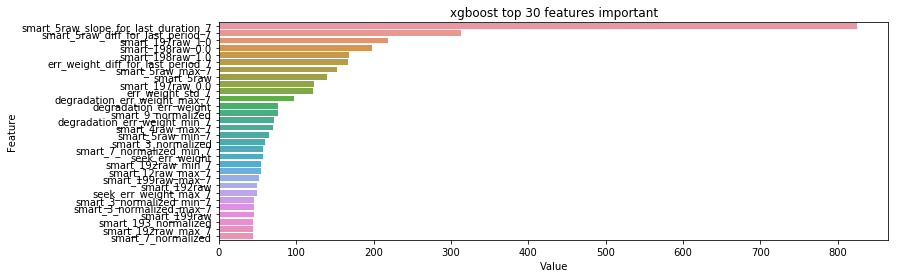

TypeError: _eval() missing 3 required positional arguments: 'val_y', 'valid_start_date', and 'valid_end_date'

In [4]:
model_params={
            'objective': 'binary:logistic', 
            'eta':0.001,
            'eval_metric': ['auc'],
            'lambda': 1.8,
            'num_boost_round': 100, 
            'subsample': 0.83,
            'num_threads': 12, 
            'random_state': 2019,
            'gamma':0.2,
            'colsample_bytree': 0.37, 
            'device': 'cpu'
            }
drop_cols = ['smart_9raw_in_day_unit']

params = {
    'model_params': model_params,
    'model_name': 'xgboost',
    'fe_filename': 'sample_by_power_on_hours_0.4_fe_df_01_01_round_2_with_smart_9raw.feather', #  fe_df_01_01_round_2.feather,sample_0.125_fe_df_01_01_round_2.feather
    'is_eval': True,
    'use_log': False,
    'drop_cols':drop_cols,
    'train_start_date': '2018-01-01',  # when using cv, should be same as the the first day of cv train
    'train_end_date': '2018-05-31', # when using cv, should be same as the the last day of cv valid
    'use_2017_fault_data':False,
    'use_next_month_fault_data':False,
    'next_month_start_date':'2018-06-01',
    'next_month_end_date':'2018-06-30',
    'valid_start_date':'2018-07-01', 
    'valid_end_date': '2018-07-31'
}
model = train(**params)